# Smartphone's Screen Crack Detection and Scoring using EfficientNet

In [1]:
# ============================================
# 0. IMPORT
# ============================================
import os, json, numpy as np, pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ============================================
# 1. CONFIG
# ============================================
IMG_SIZE   = (224, 224)
BATCH_SIZE = 16

TRAIN_DIR = "data/train"
VAL_DIR   = "data/val"
TEST_DIR  = "data/test"

MODEL_STAGE1_PATH = "exports/effnet_3class_stage1.keras"
MODEL_FINAL_PATH  = "exports/effnet_3class_best.keras"

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    brightness_range=[0.85, 1.15],
    zoom_range=0.08,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("class_indices (train):", train_gen.class_indices)

# Save class indices to JSON
with open("exports/class_indices_3class.json", "w") as f:
    json.dump(train_gen.class_indices, f)

# ============================================
# 3. CLASS WEIGHTS (KALAU IMBALANCED)
# ============================================
class_weights = None
unique_classes = np.unique(train_gen.classes)
if len(unique_classes) == 3:
    cw = compute_class_weight(
        class_weight="balanced",
        classes=unique_classes,
        y=train_gen.classes
    )
    class_weights = dict(zip(unique_classes, cw))
    print("class_weights:", class_weights)


Found 202 images belonging to 3 classes.
Found 42 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
class_indices (train): {'broken': 0, 'safe': 1, 'warning': 2}
class_weights: {np.int32(0): np.float64(0.8977777777777778), np.int32(1): np.float64(1.9803921568627452), np.int32(2): np.float64(0.7240143369175627)}


In [2]:
from pathlib import Path
from PIL import Image

root = Path("data")  # folder utama dataset kamu
bad_files = []

for img_path in root.rglob("*.jpg"):
  try:
    with Image.open(img_path) as img:
      img.verify()  # cek integritas
  except Exception as e:
    print("BAD:", img_path, "->", e)
    bad_files.append(img_path)

for f in bad_files:
  f.unlink()  # hapus file yang rusak

In [3]:
# Model building
base = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling="avg"
)

x = layers.Dense(256, activation="relu")(base.output)
x = layers.Dropout(0.4)(x)
out = layers.Dense(3, activation="softmax", name="predictions")(x)

model = models.Model(inputs=base.input, outputs=out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,278 (16.70 MB)

 Trainable params: 4,336,255 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [4]:
# Training Stage 1 – freeze backbone, train head
for layer in base.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

ckpt1 = tf.keras.callbacks.ModelCheckpoint(
    MODEL_STAGE1_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early1 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history1 = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[ckpt1, early1]
)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3854 - loss: 1.3084
Epoch 1: val_accuracy improved from None to 0.47619, saving model to exports/effnet_3class_stage1.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4010 - loss: 1.2342 - val_accuracy: 0.4762 - val_loss: 1.0562
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.5587 - loss: 0.9061
Epoch 2: val_accuracy improved from 0.47619 to 0.50000, saving model to exports/effnet_3class_stage1.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5347 - loss: 0.8807 - val_accuracy: 0.5000 - val_loss: 0.9611
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.7673 - loss: 0.7023
Epoch 3: val_accuracy did not improve from 0.50000
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7475 - loss: 0.6627 - val_accuracy: 0.5000 - val_loss: 1.0053
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.7779 - loss: 0.5951
Epoch 4: val_accuracy improved from 0.50000 to 0.619

In [5]:
# Training Stage 2 – fine-tune some layers of backbone
N_UNFREEZE = 40  # bisa kamu sesuaikan (20–60)
for layer in base.layers[-N_UNFREEZE:]:
    layer.trainable = True

# opsi: freeze BatchNorm untuk stabilitas
for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

ckpt2 = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FINAL_PATH,          # misal "effnet_3class_best.keras"
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early2 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1
)

history2 = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[ckpt2, early2]
)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.8330 - loss: 0.4471
Epoch 1: val_accuracy improved from None to 0.59524, saving model to exports/effnet_3class_best.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7673 - loss: 0.5025 - val_accuracy: 0.5952 - val_loss: 0.9856
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.8828 - loss: 0.3584
Epoch 2: val_accuracy did not improve from 0.59524
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8614 - loss: 0.3933 - val_accuracy: 0.5476 - val_loss: 0.9457
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.9027 - loss: 0.2853
Epoch 3: val_accuracy did not improve from 0.59524
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8812 - loss: 0.3137 - val_accuracy: 0.5714 - val_loss: 0.9326
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.8900 - loss: 0.2422
Epoch 4: val_accuracy did not improve from 0.59524
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.905

In [6]:
# Load best model and evaluate on test set
model = tf.keras.models.load_model(MODEL_FINAL_PATH)

test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"\nTest Loss : {test_loss:.4f}")
print(f"Test Acc  : {test_acc*100:.2f}%")

y_true = test_gen.classes
y_prob = model.predict(test_gen, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_gen.class_indices.keys())   # nama kelas sesuai folder
print("Label order:", labels)

print("\n=== Classification Report (3 kelas) ===")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

print("\n=== Confusion Matrix (3 kelas) ===")
print(confusion_matrix(y_true, y_pred))


Test Loss : 0.7784
Test Acc  : 68.49%
Label order: ['broken', 'safe', 'warning']

=== Classification Report (3 kelas) ===
              precision    recall  f1-score   support

      broken     0.7647    0.5909    0.6667        22
        safe     0.7826    0.6923    0.7347        26
     warning     0.5758    0.7600    0.6552        25

    accuracy                         0.6849        73
   macro avg     0.7077    0.6811    0.6855        73
weighted avg     0.7064    0.6849    0.6870        73


=== Confusion Matrix (3 kelas) ===
[[13  3  6]
 [ 0 18  8]
 [ 4  2 19]]


In [7]:
# Calculate severity scores and save per-image predictions
rep_map = {"safe": 10, "warning": 50, "broken": 90}
rep_scores = np.array([rep_map[c.lower()] for c in labels], dtype=float)

severity_scores = (y_prob * rep_scores).sum(axis=1)

def score_to_bucket(s: float) -> str:
    if s < 30:
        return "safe"
    elif s < 70:
        return "warning"
    else:
        return "broken"

score_bucket = np.array([score_to_bucket(s) for s in severity_scores])

filenames = test_gen.filenames
true_names = [labels[i] for i in y_true]
pred_names = [labels[i] for i in y_pred]

results_df = pd.DataFrame({
    "filename": filenames,
    "true_label": true_names,
    "pred_label": pred_names,
    "prob_" + labels[0]: y_prob[:, 0],
    "prob_" + labels[1]: y_prob[:, 1],
    "prob_" + labels[2]: y_prob[:, 2],
    "severity_score": severity_scores,
    "score_bucket": score_bucket,
})

results_df.to_csv("exports/test_predictions_3class.csv", index=False)
print("\nSaved per-image predictions to: test_predictions_3class.csv")



Saved per-image predictions to: test_predictions_3class.csv


In [8]:
# Export model
VISION_MODEL_DIR = "models/image"
EXPORT_VERSION = "latest"

# Create export directory
export_dir = os.path.join(VISION_MODEL_DIR, EXPORT_VERSION)
os.makedirs(export_dir, exist_ok=True)
print("Export directory:", export_dir)

# Save model in keras format
model_export_path = os.path.join(export_dir, "model.keras")
model.save(model_export_path)
print("Saved model to: ", model_export_path)

# Take info from generator and scoring rules
img_h, img_w, img_c = test_gen.image_shape

# Label mapping from generator
labels = list(test_gen.class_indices.keys())
class_indices = test_gen.class_indices
idx_to_label = {int(v): k for k, v in class_indices.items()}

# Representation score mapping
rep_score_map = {
  "safe": 10,
  "warning": 50,
  "broken": 90
}

# Severity weights and thresholds
severity_weights = {
  "safe": 0.0,
  "warning": 0.3,
  "broken": 0.7
}

# Bucket thresholds
bucket_threshold = {
  "safe_max": 30.0,
  "warning_max": 70.0
}

Export directory: models/image\latest
Saved model to:  models/image\latest\model.keras


In [9]:
config = {
  "image_height": int(img_h),
  "image_width": int(img_w),
  "channels": int(img_c),
  "rescale": 1.0 / 255.0,
  "labels": labels,
  "class_indices": class_indices,
  "idx_to_label": idx_to_label,     
  # scoring & bucket
  "rep_score_map": rep_score_map,
  "severity_weights": severity_weights,
  "bucket_thresholds": bucket_threshold,
  # optional metadata
  "model_type": "efficientnet_b0_screen_damage",
  "version": EXPORT_VERSION,
}

config_path = os.path.join(export_dir, "config.json")
with open(config_path, "w") as f:
  json.dump(config, f, indent=2)

print("Saved config to:", config_path)

Saved config to: models/image\latest\config.json


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

print("\n======================")
print("📌 1. Jumlah Data Train / Val / Test")
print("======================")

# TRAIN COUNT
train_count = len(train_gen.classes)
val_count = len(val_gen.classes)
test_count = len(test_gen.classes)

print(f"Train samples : {train_count}")
print(f"Val samples   : {val_count}")
print(f"Test samples  : {test_count}")

# Kelas per subset
import collections
print("\nDistribusi Train:", collections.Counter(train_gen.classes))
print("Distribusi Val  :", collections.Counter(val_gen.classes))
print("Distribusi Test :", collections.Counter(test_gen.classes))


print("\n======================")
print("📌 2. Evaluasi Model (Precision, Recall, F1)")
print("======================")

print(classification_report(y_true, y_pred, target_names=labels, digits=4))


print("\n======================")
print("📌 3. Confusion Matrix")
print("======================")

cm = confusion_matrix(y_true, y_pred)
print(cm)

# Jika ingin tampilkan dalam bentuk tabel rapi:
cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels],
  columns=[f"pred_{l}" for l in labels])
cm_df



📌 1. Jumlah Data Train / Val / Test
Train samples : 202
Val samples   : 42
Test samples  : 73

Distribusi Train: Counter({np.int32(2): 93, np.int32(0): 75, np.int32(1): 34})
Distribusi Val  : Counter({np.int32(2): 19, np.int32(0): 16, np.int32(1): 7})
Distribusi Test : Counter({np.int32(1): 26, np.int32(2): 25, np.int32(0): 22})

📌 2. Evaluasi Model (Precision, Recall, F1)
              precision    recall  f1-score   support

      broken     0.7647    0.5909    0.6667        22
        safe     0.7826    0.6923    0.7347        26
     warning     0.5758    0.7600    0.6552        25

    accuracy                         0.6849        73
   macro avg     0.7077    0.6811    0.6855        73
weighted avg     0.7064    0.6849    0.6870        73


📌 3. Confusion Matrix
[[13  3  6]
 [ 0 18  8]
 [ 4  2 19]]


,pred_broken,pred_safe,pred_warning
true_broken,13,3,6
true_safe,0,18,8
true_warning,4,2,19



📌 Confusion Matrix (Tabel)


,Pred_broken,Pred_safe,Pred_warning
True_broken,13,3,6
True_safe,0,18,8
True_warning,4,2,19


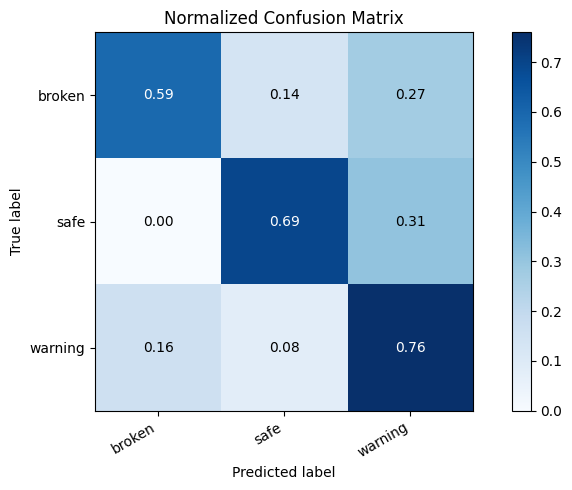

In [13]:
# ============================================
# Confusion Matrix: tabel + heatmap
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Pastikan variabel ini sudah ada dari cell sebelumnya:
# y_true, y_pred, labels

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"True_{l}" for l in labels],
    columns=[f"Pred_{l}" for l in labels]
)

print("\n======================")
print("📌 Confusion Matrix (Tabel)")
print("======================")
display(cm_df)  # kalau di notebook, ini bikin tabel rapi

# Normalisasi per baris (supaya bisa lihat proporsi per kelas)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 5))
im = plt.imshow(cm_norm, interpolation="nearest", cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.colorbar(im, fraction=0.046, pad=0.04)

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=30, ha="right")
plt.yticks(tick_marks, labels)

# Tulis nilai di setiap kotak
thresh = cm_norm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, f"{cm_norm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > thresh else "black"
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


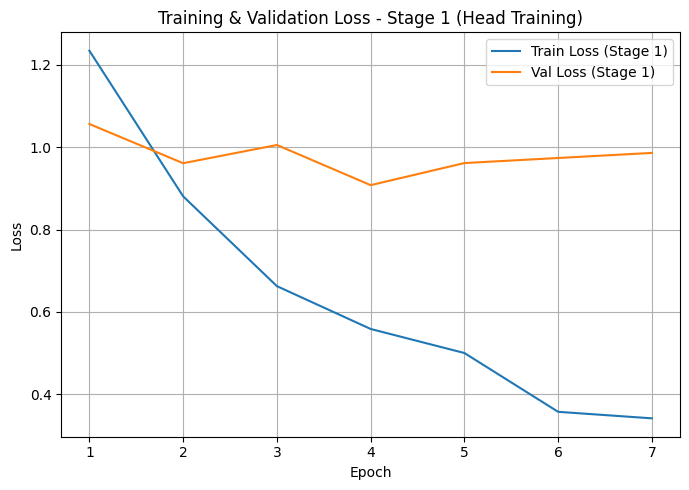

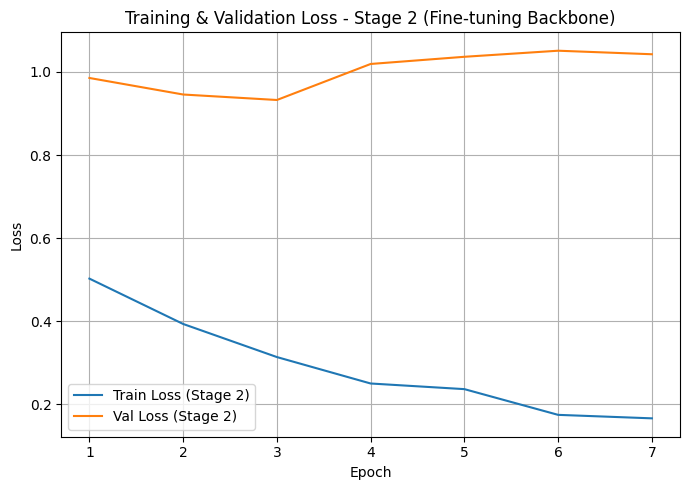

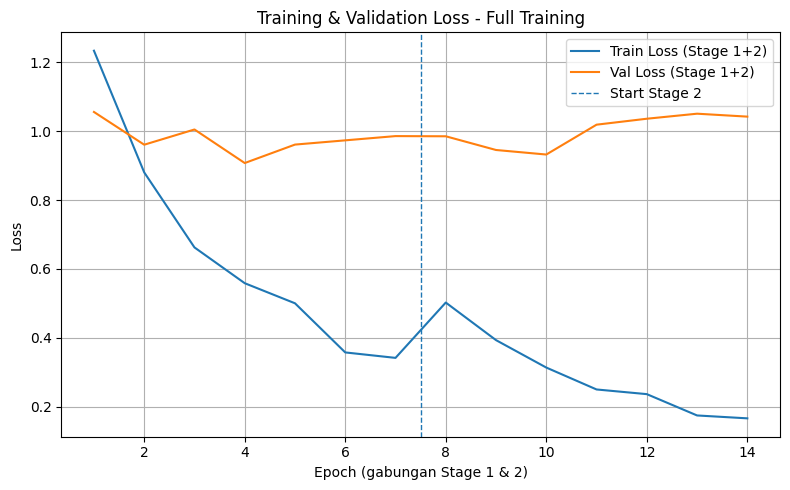

In [12]:
# ============================================
# Plot Training & Validation Loss
# (Stage 1 dan Stage 2 EfficientNet)
# ============================================
import matplotlib.pyplot as plt

# Pastikan history1 dan history2 sudah ada dari cell training
# history1 = model.fit(... Stage 1 ...)
# history2 = model.fit(... Stage 2 ...)

# --- Stage 1 ---
loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]

# --- Stage 2 ---
loss2 = history2.history["loss"]
val_loss2 = history2.history["val_loss"]

# --------- Plot terpisah per stage ---------
plt.figure(figsize=(7, 5))
epochs1 = range(1, len(loss1) + 1)
plt.plot(epochs1, loss1, label="Train Loss (Stage 1)")
plt.plot(epochs1, val_loss1, label="Val Loss (Stage 1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss - Stage 1 (Head Training)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
epochs2 = range(1, len(loss2) + 1)
plt.plot(epochs2, loss2, label="Train Loss (Stage 2)")
plt.plot(epochs2, val_loss2, label="Val Loss (Stage 2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss - Stage 2 (Fine-tuning Backbone)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------- Plot gabungan Stage 1 + Stage 2 ---------
loss_all = loss1 + loss2
val_loss_all = val_loss1 + val_loss2
epochs_all = range(1, len(loss_all) + 1)

boundary_epoch = len(loss1)  # batas antara Stage 1 & 2

plt.figure(figsize=(8, 5))
plt.plot(epochs_all, loss_all, label="Train Loss (Stage 1+2)")
plt.plot(epochs_all, val_loss_all, label="Val Loss (Stage 1+2)")

# garis vertikal penanda mulai Stage 2
plt.axvline(boundary_epoch + 0.5, linestyle="--", linewidth=1, label="Start Stage 2")

plt.xlabel("Epoch (gabungan Stage 1 & 2)")
plt.ylabel("Loss")
plt.title("Training & Validation Loss - Full Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# ============================================
# F1 Score: per kelas + macro + weighted
# ============================================

# F1 per kelas (array)
f1_per_class = f1_score(y_true, y_pred, average=None)

# F1 macro & weighted
macro_f1 = f1_score(y_true, y_pred, average="macro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

f1_df = pd.DataFrame({
    "class": labels,
    "F1_per_class": f1_per_class
})

print("\n======================")
print("📌 F1 Score per Kelas")
print("======================")
display(f1_df)

print("\n======================")
print("📌 F1 Score Global")
print("======================")
print(f"Macro F1    : {macro_f1:.4f}")
print(f"Weighted F1 : {weighted_f1:.4f}")

print("\n📌 Classification Report detail:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))



📌 F1 Score per Kelas


,class,F1_per_class
0,broken,0.666667
1,safe,0.734694
2,warning,0.655172



📌 F1 Score Global
Macro F1    : 0.6855
Weighted F1 : 0.6870

📌 Classification Report detail:
              precision    recall  f1-score   support

      broken     0.7647    0.5909    0.6667        22
        safe     0.7826    0.6923    0.7347        26
     warning     0.5758    0.7600    0.6552        25

    accuracy                         0.6849        73
   macro avg     0.7077    0.6811    0.6855        73
weighted avg     0.7064    0.6849    0.6870        73

